PASO 8A: ANÁLISIS COMPLETO PARA DECISIÓN DE MULTICOLINEALIDAD

📂 1. Cargando dataset transformado...

✅ Dataset cargado: 538 filas × 42 columnas

Variables predictoras: 41
Variable objetivo: SOP (S/N)
Distribución objetivo: {0: 362, 1: 176}

🌲 2. FEATURE IMPORTANCE (RANDOM FOREST)

🔍 Entrenando Random Forest para calcular importancia...
   (Esto puede tomar 1-2 minutos)

Variables numéricas: 41

✅ Feature Importance calculado

📊 TOP 20 Variables más importantes:
                 Variable  Importance
        Num Folículos (D)    0.184586
        Num Folículos (I)    0.124219
Oscurecimiento Piel (S/N)    0.055802
  Crecimiento Vello (S/N)    0.050410
       Aumento Peso (S/N)    0.049008
              AMH (ng/mL)    0.034920
              Ciclo (R/I)    0.034914
    Duración Ciclo (días)    0.033233
              LH (mUI/mL)    0.022414
                Peso (Kg)    0.021875
             Ratio FSH/LH    0.021869
      Comida Rápida (S/N)    0.021847
          Endometrio (mm)    0.021129
 

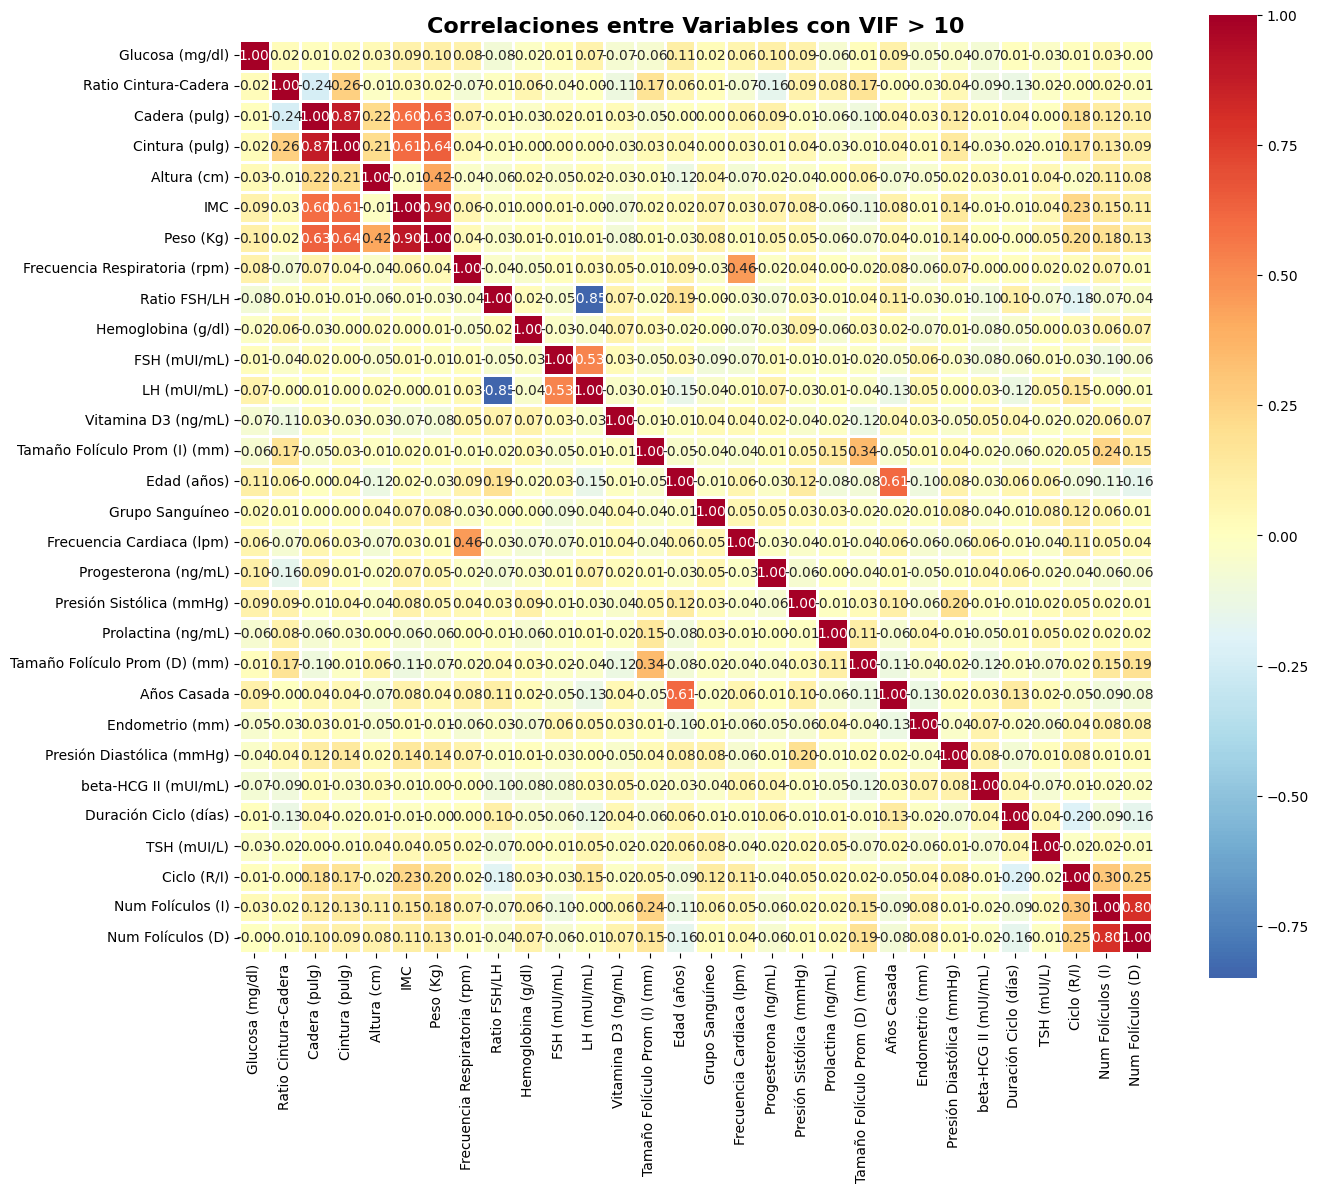

In [2]:
"""
PASO 8A: ANÁLISIS COMPLETO PREVIO A DECISIÓN DE MULTICOLINEALIDAD

Proyecto: Análisis y Predicción de SOP
Fecha: 1 noviembre 2025
Objetivo: Generar TODOS los análisis necesarios para decidir qué variables eliminar

IMPORTANTE:
- TODAS las variables analizadas (sin tops ni filtros)
- Feature Importance completo
- Correlaciones completas
- Tabla de decisión integrada
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PASO 8A: ANÁLISIS COMPLETO PARA DECISIÓN DE MULTICOLINEALIDAD")
print("="*80)
print()

# =============================================================================
# 1. CARGAR DATASET
# =============================================================================

print("📂 1. Cargando dataset transformado...")
print()

# AJUSTA LA RUTA según tu sistema
df = pd.read_csv('../documentos_generados/PCOS_data_transformado.csv')

print(f"✅ Dataset cargado: {df.shape[0]} filas × {df.shape[1]} columnas")
print()

# Identificar variable objetivo
target_col = 'SOP (S/N)'  # AJUSTA si tu columna se llama diferente

# Verificar que existe
if target_col not in df.columns:
    print("⚠️ ADVERTENCIA: Ajusta el nombre de la variable objetivo")
    print(f"Columnas disponibles: {df.columns.tolist()}")
    
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {target_col}")
print(f"Distribución objetivo: {y.value_counts().to_dict()}")
print()

# =============================================================================
# 2. FEATURE IMPORTANCE (RANDOM FOREST) - TODAS LAS VARIABLES
# =============================================================================

print("="*80)
print("🌲 2. FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*80)
print()

print("🔍 Entrenando Random Forest para calcular importancia...")
print("   (Esto puede tomar 1-2 minutos)")
print()

# Preparar datos (solo numéricas para RF básico)
X_numeric = X.select_dtypes(include=[np.number])

print(f"Variables numéricas: {len(X_numeric.columns)}")
print()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Feature Importance
feature_importance = pd.DataFrame({
    'Variable': X_numeric.columns,
    'Importance': rf.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance = feature_importance.reset_index(drop=True)

# Guardar
feature_importance.to_csv('feature_importance_completo.csv', index=False)

print("✅ Feature Importance calculado")
print()
print("📊 TOP 20 Variables más importantes:")
print(feature_importance.head(20).to_string(index=False))
print()
print(f"📁 Guardado: feature_importance_completo.csv ({len(feature_importance)} variables)")
print()

# Accuracy para referencia
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"📈 Random Forest Accuracy:")
print(f"   Train: {train_score:.4f}")
print(f"   Test:  {test_score:.4f}")
print()

# =============================================================================
# 3. MATRIZ DE CORRELACIÓN COMPLETA
# =============================================================================

print("="*80)
print("🔗 3. MATRIZ DE CORRELACIÓN (PEARSON) - TODAS LAS VARIABLES")
print("="*80)
print()

print("🔍 Calculando correlaciones...")
print()

# Correlación Pearson
corr_matrix = X_numeric.corr()

# Guardar matriz completa
corr_matrix.to_csv('matriz_correlacion_completa.csv')
print(f"✅ Matriz {corr_matrix.shape[0]}×{corr_matrix.shape[1]} guardada")
print(f"📁 Guardado: matriz_correlacion_completa.csv")
print()

# Encontrar pares con alta correlación
print("🔍 Buscando pares con correlación |r| > 0.7...")
print()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        r = corr_matrix.iloc[i, j]
        
        if abs(r) > 0.7:
            high_corr_pairs.append({
                'Variable_1': var1,
                'Variable_2': var2,
                'Correlacion': r,
                'Correlacion_Abs': abs(r)
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
high_corr_df = high_corr_df.sort_values('Correlacion_Abs', ascending=False)
high_corr_df.to_csv('pares_alta_correlacion_completo.csv', index=False)

print(f"✅ Encontrados {len(high_corr_df)} pares con |r| > 0.7")
print()
print("📊 Pares con mayor correlación:")
print(high_corr_df.head(20).to_string(index=False))
print()
print(f"📁 Guardado: pares_alta_correlacion_completo.csv")
print()

# =============================================================================
# 4. CORRELACIONES ENTRE VARIABLES VIF ALTO (>10)
# =============================================================================

print("="*80)
print("🔍 4. CORRELACIONES ESPECÍFICAS ENTRE VARIABLES VIF > 10")
print("="*80)
print()

# Primero necesitamos calcular VIF
print("🔍 Calculando VIF de todas las variables...")
print()

X_vif = X_numeric.values
vif_data = pd.DataFrame()
vif_data['Variable'] = X_numeric.columns

vif_scores = []
for i in range(len(X_numeric.columns)):
    vif = variance_inflation_factor(X_vif, i)
    vif_scores.append(vif)

vif_data['VIF'] = vif_scores
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

# Variables con VIF > 10
vars_vif_alto = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()

print(f"✅ Variables con VIF > 10: {len(vars_vif_alto)}")
print()
print("📊 Variables problemáticas:")
print(vif_data[vif_data['VIF'] > 10].to_string(index=False))
print()

if len(vars_vif_alto) > 0:
    # Matriz de correlación solo variables problemáticas
    corr_vif_alto = X_numeric[vars_vif_alto].corr()
    
    # Guardar
    corr_vif_alto.to_csv('correlaciones_variables_vif_alto.csv')
    print(f"✅ Matriz {corr_vif_alto.shape[0]}×{corr_vif_alto.shape[1]} de variables VIF>10 guardada")
    print(f"📁 Guardado: correlaciones_variables_vif_alto.csv")
    print()
    
    # Visualización
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_vif_alto, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                center=0, square=True, linewidths=1)
    plt.title('Correlaciones entre Variables con VIF > 10', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('heatmap_correlaciones_vif_alto.png', dpi=300, bbox_inches='tight')
    print("✅ Heatmap guardado: heatmap_correlaciones_vif_alto.png")
    print()
    
    # Identificar grupos de variables altamente correlacionadas
    print("🔍 Analizando grupos de variables correlacionadas...")
    print()
    
    for var in vars_vif_alto:
        correlaciones = corr_vif_alto[var].drop(var).sort_values(ascending=False)
        high_corr = correlaciones[abs(correlaciones) > 0.5]
        
        if len(high_corr) > 0:
            print(f"📌 {var} (VIF={vif_data[vif_data['Variable']==var]['VIF'].values[0]:.1f}):")
            print(f"   Correlaciona con:")
            for other_var, r in high_corr.items():
                print(f"   • {other_var}: r={r:.3f}")
            print()

# =============================================================================
# 5. SIGNIFICANCIA ESTADÍSTICA (MANN-WHITNEY) - TODAS LAS VARIABLES
# =============================================================================

print("="*80)
print("📊 5. SIGNIFICANCIA ESTADÍSTICA (MANN-WHITNEY U)")
print("="*80)
print()

print("🔍 Calculando Mann-Whitney U para todas las variables...")
print()

# Separar grupos
grupo_sop = df[df[target_col] == 1]
grupo_no_sop = df[df[target_col] == 0]

significancia = []

for col in X_numeric.columns:
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(
        grupo_sop[col].dropna(),
        grupo_no_sop[col].dropna(),
        alternative='two-sided'
    )
    
    # Cohen's d (tamaño del efecto)
    mean_sop = grupo_sop[col].mean()
    mean_no_sop = grupo_no_sop[col].mean()
    std_pooled = np.sqrt(
        ((len(grupo_sop)-1)*grupo_sop[col].std()**2 + 
         (len(grupo_no_sop)-1)*grupo_no_sop[col].std()**2) / 
        (len(grupo_sop) + len(grupo_no_sop) - 2)
    )
    cohens_d = (mean_sop - mean_no_sop) / std_pooled if std_pooled > 0 else 0
    
    significancia.append({
        'Variable': col,
        'U_statistic': stat,
        'p_valor': p_value,
        'Cohens_d': cohens_d,
        'Significativo': 'Sí' if p_value < 0.05 else 'No',
        'Media_SOP': mean_sop,
        'Media_No_SOP': mean_no_sop
    })

significancia_df = pd.DataFrame(significancia)
significancia_df = significancia_df.sort_values('p_valor').reset_index(drop=True)

# Guardar
significancia_df.to_csv('significancia_estadistica_completa.csv', index=False)

print(f"✅ Análisis de significancia completado para {len(significancia_df)} variables")
print()
print("📊 TOP 20 Variables más significativas:")
print(significancia_df.head(20)[['Variable', 'p_valor', 'Cohens_d', 'Significativo']].to_string(index=False))
print()
print(f"📁 Guardado: significancia_estadistica_completa.csv")
print()

# Resumen
sig_count = (significancia_df['p_valor'] < 0.05).sum()
print(f"📈 Resumen: {sig_count}/{len(significancia_df)} variables son significativas (p < 0.05)")
print()

# =============================================================================
# 6. TABLA INTEGRADA DE DECISIÓN - TODAS LAS VARIABLES
# =============================================================================

print("="*80)
print("📋 6. TABLA INTEGRADA DE DECISIÓN")
print("="*80)
print()

print("🔍 Integrando todos los análisis...")
print()

# Merge todos los análisis
tabla_decision = vif_data.copy()

# Agregar Feature Importance
tabla_decision = tabla_decision.merge(
    feature_importance[['Variable', 'Importance']], 
    on='Variable', 
    how='left'
)

# Agregar Significancia
tabla_decision = tabla_decision.merge(
    significancia_df[['Variable', 'p_valor', 'Cohens_d', 'Significativo']], 
    on='Variable', 
    how='left'
)

# Clasificar VIF
tabla_decision['Clasificacion_VIF'] = tabla_decision['VIF'].apply(
    lambda x: 'SEVERO (>10)' if x > 10 else ('MODERADO (5-10)' if x > 5 else 'OK (<5)')
)

# Agregar columna de correlaciones principales
correlaciones_principales = []

for var in tabla_decision['Variable']:
    if var in corr_matrix.columns:
        # Encontrar las 3 variables con mayor correlación (excluyendo consigo misma)
        corrs = corr_matrix[var].drop(var).sort_values(ascending=False)
        top_corrs = []
        
        for other_var, r in corrs.head(3).items():
            if abs(r) > 0.3:  # Solo si correlación notable
                top_corrs.append(f"{other_var} (r={r:.2f})")
        
        correlaciones_principales.append("; ".join(top_corrs) if top_corrs else "Ninguna >0.3")
    else:
        correlaciones_principales.append("N/A")

tabla_decision['Correlaciones_Principales'] = correlaciones_principales

# Sugerencia de decisión (reglas heurísticas)
def sugerir_decision(row):
    """
    Reglas para sugerir decisión:
    1. VIF > 100 → Eliminar casi siempre
    2. VIF 50-100 + Importance < 0.01 → Eliminar
    3. VIF 10-50 + No significativo (p>0.05) → Considerar eliminar
    4. VIF < 10 → Mantener
    """
    vif = row['VIF']
    importance = row['Importance'] if pd.notna(row['Importance']) else 0
    p_val = row['p_valor'] if pd.notna(row['p_valor']) else 1
    
    if vif > 100:
        return "🔴 ELIMINAR (VIF extremo)"
    elif vif > 50:
        if importance < 0.01:
            return "🔴 ELIMINAR (VIF alto + baja importancia)"
        else:
            return "🟡 EVALUAR (VIF alto pero importante)"
    elif vif > 10:
        if p_val > 0.05:
            return "🟡 CONSIDERAR ELIMINAR (VIF>10 + no significativo)"
        else:
            return "🟡 EVALUAR (VIF>10 pero significativo)"
    else:
        return "🟢 MANTENER (VIF aceptable)"

tabla_decision['Decision_Sugerida'] = tabla_decision.apply(sugerir_decision, axis=1)

# Ordenar por VIF descendente
tabla_decision = tabla_decision.sort_values('VIF', ascending=False).reset_index(drop=True)

# Guardar
tabla_decision.to_csv('tabla_decision_multicolinealidad_COMPLETA.csv', index=False)

print(f"✅ Tabla de decisión generada: {len(tabla_decision)} variables")
print()
print("📊 TODAS LAS VARIABLES (ordenadas por VIF):")
print()
print(tabla_decision[['Variable', 'VIF', 'Importance', 'p_valor', 
                      'Clasificacion_VIF', 'Decision_Sugerida']].to_string(index=False))
print()
print(f"📁 Guardado: tabla_decision_multicolinealidad_COMPLETA.csv")
print()

# =============================================================================
# 7. RESUMEN Y RECOMENDACIONES
# =============================================================================

print("="*80)
print("📋 7. RESUMEN EJECUTIVO")
print("="*80)
print()

# Contar por categorías
vif_severo = (tabla_decision['VIF'] > 10).sum()
vif_moderado = ((tabla_decision['VIF'] > 5) & (tabla_decision['VIF'] <= 10)).sum()
vif_ok = (tabla_decision['VIF'] <= 5).sum()

eliminar_sugerido = tabla_decision['Decision_Sugerida'].str.contains('ELIMINAR').sum()
evaluar_sugerido = tabla_decision['Decision_Sugerida'].str.contains('EVALUAR').sum()
mantener_sugerido = tabla_decision['Decision_Sugerida'].str.contains('MANTENER').sum()

print("📊 ESTADO DE MULTICOLINEALIDAD:")
print(f"   🔴 VIF SEVERO (>10):     {vif_severo} variables ({vif_severo/len(tabla_decision)*100:.1f}%)")
print(f"   🟡 VIF MODERADO (5-10):  {vif_moderado} variables ({vif_moderado/len(tabla_decision)*100:.1f}%)")
print(f"   🟢 VIF OK (<5):          {vif_ok} variables ({vif_ok/len(tabla_decision)*100:.1f}%)")
print()

print("💡 RECOMENDACIONES AUTOMÁTICAS:")
print(f"   🔴 ELIMINAR:             {eliminar_sugerido} variables")
print(f"   🟡 EVALUAR:              {evaluar_sugerido} variables")
print(f"   🟢 MANTENER:             {mantener_sugerido} variables")
print()

# Mostrar variables sugeridas para eliminación
vars_eliminar = tabla_decision[tabla_decision['Decision_Sugerida'].str.contains('ELIMINAR')]

if len(vars_eliminar) > 0:
    print("🔴 VARIABLES SUGERIDAS PARA ELIMINACIÓN:")
    print()
    for idx, row in vars_eliminar.iterrows():
        print(f"   {idx+1}. {row['Variable']}")
        print(f"      VIF: {row['VIF']:.1f}")
        print(f"      Importance: {row['Importance']:.4f}")
        print(f"      p-valor: {row['p_valor']:.4f}")
        print(f"      Correlaciona con: {row['Correlaciones_Principales']}")
        print()

print("="*80)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*80)
print()

print("📁 ARCHIVOS GENERADOS:")
print("   1. feature_importance_completo.csv")
print("   2. matriz_correlacion_completa.csv")
print("   3. pares_alta_correlacion_completo.csv")
print("   4. correlaciones_variables_vif_alto.csv")
print("   5. heatmap_correlaciones_vif_alto.png")
print("   6. significancia_estadistica_completa.csv")
print("   7. tabla_decision_multicolinealidad_COMPLETA.csv  ← PRINCIPAL")
print()

print("🎯 SIGUIENTE PASO:")
print("   Revisa 'tabla_decision_multicolinealidad_COMPLETA.csv'")
print("   Decide qué variables eliminar basándote en:")
print("   - VIF")
print("   - Feature Importance")
print("   - Significancia estadística")
print("   - Correlaciones")
print("   - Relevancia clínica (tu criterio de QFB)")
print()

print("="*80)